In [ ]:
%load_ext autoreload
%autoreload 2
import sys
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
import joblib
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR
from neuro.config import brain_drive_resps_dir
import analyze_helper
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples

### load average flatmaps per explanation braindrive

In [ ]:
brain_drive_flatmaps_metadata = '/home/chansingh/automated-explanations/results/processed/flatmaps/flatmaps_metadata.pkl'
brain_drive_avgs = joblib.load(brain_drive_flatmaps_metadata)

In [ ]:
brain_drive_avgs

### load weights per question

In [ ]:
# load questions model weights
results_dir = analyze_helper.best_results_dir
rr, cols_varied, mets = analyze_helper.load_clean_results(results_dir)
metric_sort = 'corrs_tune_pc_weighted_mean'

In [ ]:
# # pick model to interpret
# r = rr
# r = r[r.qa_questions_version == 'v3_boostexamples_merged']
# r = r[r.num_stories == -1]
# r = r[r.weight_enet_mask_num_nonzero == 35]
# r = r[r.feature_space == 'qa_embedder']
# cols_varied = [c for c in cols_varied if not c in ['num_stories',
#                                                    'feature_selection_alpha', 'feature_selection_stability_seeds']]
# flatmaps_per_question = __import__('06_flatmaps_per_question')
# args0 = r[r.subject == 'S02'].iloc[0]
# weights, weights_pc = flatmaps_per_question.get_weights_top(args0)
# qs_selected = questions[args0['weight_enet_mask']]
# df_w = pd.DataFrame({'question': qs_selected, 'weights': [
#                     w for w in weights]}).set_index('question')
joblib.dump((args0, qs_selected, df_w),
            '../qa_results/processed/selected_weights.pkl')

In [ ]:
args0, qs_selected, df_w = joblib.load(
    '../qa_results/processed/selected_weights.pkl')

### Make comparison

In [ ]:
df_w

In [231]:
# matches
qa_list = [
    'Is time mentioned in the input?',
    'Does the input contain a measurement?',
    'Does the input contain a number?',
    'Does the sentence mention a specific location?',
    'Does the sentence describe a relationship between people?',
    'Does the sentence describe a relationship between people?',
    'Does the text describe a mode of communication?',
    # 'Does the sentence contain a negation?',
]
wt_qas = df_w.loc[qa_list]['weights'].values
bd_list = [
    ('time', 212),
    ('measurements', 171),
    ('measurements', 171),
    # ('moments',	337),
    # ('locations', 122),
    ('locations', 368),
    ('emotion', 179),
    ('emotional expression', 398),
    ('communication', 299),
    # ('negativity', 248)
]

wt_bds = pd.concat([
    brain_drive_avgs[
        (brain_drive_avgs.expl == bd_list[i][0]) & (
            brain_drive_avgs.module_num == bd_list[i][1])

    ]
    for i in range(len(bd_list))
])['resp_chunks'].values


mask = args0['corrs_test'] >= 0
wt_qas = [wt_qa[mask] for wt_qa in wt_qas]
wt_bds = [wt_bd[mask] for wt_bd in wt_bds]

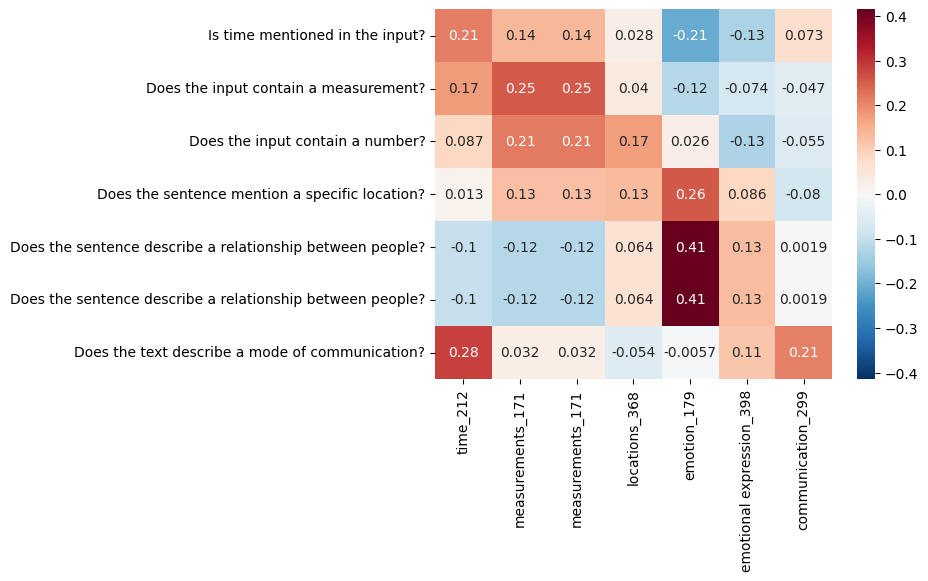

In [234]:
corrs = pd.DataFrame(
    np.zeros((len(qa_list), len(bd_list))), columns=[
        f'{bd_list[i][0]}_{bd_list[i][1]}' for i in range(len(bd_list))], index=qa_list)
for i, qa in enumerate(qa_list):
    for j, bd in enumerate(bd_list):
        corrs.iloc[i, j] = np.corrcoef(wt_qas[i], wt_bds[j])[0, 1]

# normalize each column
# corrs = corrs / corrs.abs().max()
# normalize each row to mean zero stddev 1
# corrs = (corrs - corrs.mean()) / corrs.std()
vmax = np.max(np.abs(corrs.values))
# sns.clustermap(corrs, annot=True, cmap='RdBu', vmin=-vmax, vmax=vmax)
sns.heatmap(corrs, annot=True, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
# sasc.viz.outline_diagonal(corrs.values.shape, )
plt.show()

In [ ]:
def quickshow(vals, subject='S02', clab=None, with_rois=False, cmap='RdBu', with_borders=False):
    vabs = max(np.abs(vals))

    # cmap = sns.diverging_palette(12, 210, as_cmap=True)
    # cmap = sns.diverging_palette(16, 240, as_cmap=True)

    vol = cortex.Volume(
        vals, 'UT' + subject, xfmname=f'UT{subject}_auto', vmin=-vabs, vmax=vabs, cmap=cmap)

    cortex.quickshow(vol,
                     with_rois=with_rois,
                     with_labels=False,
                     with_borders=with_borders,
                     with_colorbar=clab == None,  # if not None, save separate cbar
                     )


quickshow(wt_qa)
# quickshow(wt_bd)